# Solar System Barycenter (SSB) 
Location of the SSB over time.

In [1]:
# Import modules
import datetime
import spiceypy as sp
import numpy as np

# Load the SPICE kernels via a meta file
sp.furnsh('kernel_meta.txt')

In [2]:
# We want to compute the Solar System barycentre (SSB) w.r.t to the centre of
# the Sun for a certain time interval
# First, we set an initial time in UTC.
T1_UTC = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
DDAYS = 10000
T2_UTC = T1_UTC + datetime.timedelta(days=DDAYS)

# Convert the datetime objects now to strings
T1_UTC_STR = T1_UTC.strftime('%Y-%m-%dT%H:%M:%S')
T2_UTC_STR = T2_UTC.strftime('%Y-%m-%dT%H:%M:%S')

# Print the starting and end times
print(f"Init time in UTC: {T1_UTC_STR:s}")
print(f"End time in UTC: {T2_UTC_STR:s}\n")

# Convert to Ephemeris Time (ET) using the SPICE function utc2et.
T1_ET = sp.utc2et(T1_UTC_STR)
T2_ET = sp.utc2et(T2_UTC_STR)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [3]:
# A day has 86400 seconds (24 hours * 60 minutes * 60 seconds)
# In our example, we set a time period of 10000 days. Thus, we expect the
# difference between T1_ET and T2_ET to be 10000*86400 seconds
# Let's have a look at the delta.
print(f'Added leap-seconds: {T2_ET - T1_ET - DDAYS*86400:.7f}\n')
# We see that 5.0012845 seconds are added in this time period (leap-seconds)

# Create a numpy array that covers a time interval in delta = 1 day step
times_et = np.linspace(T1_ET, T2_ET, DDAYS)

Added leap-seconds: 5.0012845



In [4]:
# Now we compute the position of the Solar System's barycentre w.r.t. our Sun:
# position of the SSB w.r.t. the Sun. We use the function spkgps.

# spkgps gives position vector and light-time (time of flight) for a target.
ssb_hel = np.array([sp.spkgps(targ=0, et=t_et, ref='ECLIPJ2000', obs=10)[0] for t_et in times_et])

In [5]:
print(
    'Position (components) of the Solar System Barycentre w.r.t the centre of the Sun (at initial time): \n'
    + 'X = {:+10.1f} km\nY = {:+10.1f} km\nZ = {:+10.1f} km\n'.format(*ssb_hel[0])
)

print(
    'Distance between the Solar System Barycentre w.r.t the centre of the Sun (at initial time): \n'
    f'd = {np.linalg.norm(ssb_hel[0]):9.1f} km\n'
)

Position (components) of the Solar System Barycentre w.r.t the centre of the Sun (at initial time): 
X = +1068000.2 km
Y =  +417680.9 km
Z =   -30844.7 km

Distance between the Solar System Barycentre w.r.t the centre of the Sun (at initial time): 
d = 1147184.9 km



In [6]:
sp.bodvcd?

Signature: sp.bodvcd(bodyid: int, item: str, maxn: int) -> Tuple[int, numpy.ndarray]
Docstring:
Fetch from the kernel pool the double precision values of an item
associated with a body, where the body is specified by an integer ID
code.

https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/bodvcd_c.html

:param bodyid: Body ID code.
:param item:
            Item for which values are desired,
            ("RADII", "NUT_PREC_ANGLES", etc.)
:param maxn: Maximum number of values that may be returned.
:return: dim, values
File:      ~/mambaforge/envs/spherex/lib/python3.11/site-packages/spiceypy/spiceypy.py
Type:      function

In [7]:
# Scale the x, y, z component w.r.t the radius of the Sun.
_, R_SUN = sp.bodvcd(bodyid=10, item='RADII', maxn=3)
print(R_SUN)

R_SUN = R_SUN[0]

# Scale the position values using the Sun's radius
ssb_hel_scaled = ssb_hel / R_SUN

[696000. 696000. 696000.]


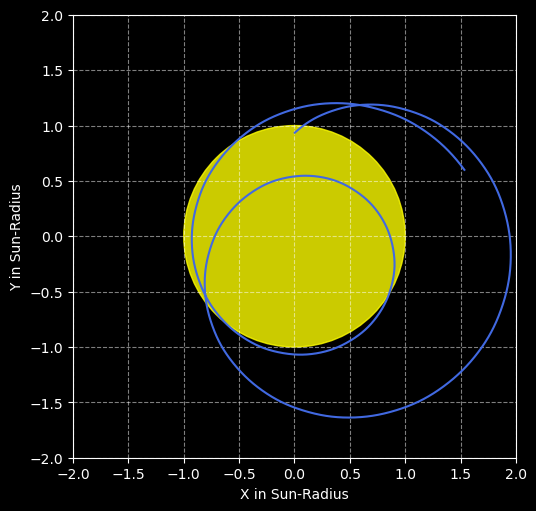

In [8]:
# We plot now the trajectory of the SSB w.r.t the Sun using matplotlib
from matplotlib import pyplot as plt

# Set a dark background... since... space is dark
plt.style.use('dark_background')

# Create a figure and ax.
fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

ax1 = axs

# Create a yellow circle that represents the Sun, add it to the ax
_sun_circ = plt.Circle((0.0, 0.0), 1.0, color='yellow', alpha=0.8)
ax1.add_artist(_sun_circ)

# Plot the SSB movement
ax1.plot(ssb_hel_scaled[:, 0], ssb_hel_scaled[:, 1], ls="-", color='royalblue')

# Set some parameters for the plot, set an equal ratio, set a grid, and set
# the x and y limits
ax1.set_aspect('equal')
ax1.grid(True, linestyle='dashed', alpha=0.5)
ax1.set(
    xlim=(-2, 2),
    ylim=(-2, 2),
    xlabel='X in Sun-Radius',
    ylabel='Y in Sun-Radius',
)

plt.show()

In [12]:
# How many days is the SSB outside the Sun?
# First, we compute the euclidean distance between the SSB and Sun.

ssb_hel_scaled_norm = np.linalg.norm(ssb_hel_scaled, axis=1)

print(f'Computation time: {DDAYS} days\n')

# Compute number of days outside the Sun
ssb_hel_outside_sun = np.count_nonzero(ssb_hel_scaled_norm > 1)

print(f'Fraction of time where the SSB was outside the Sun: {100 * ssb_hel_outside_sun/DDAYS:.1f} %')

Computation time: 10000 days

Fraction of time where the SSB was outside the Sun: 64.6 %
